In [1]:
! pip install optuna

In [2]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [3]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

import optuna
from tqdm import tqdm

Random Seed:  999


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("splcher/animefacedataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animefacedataset


In [5]:
# Root directory for dataset
dataroot = path

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [6]:
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root=dataroot,
                               transform = transform)

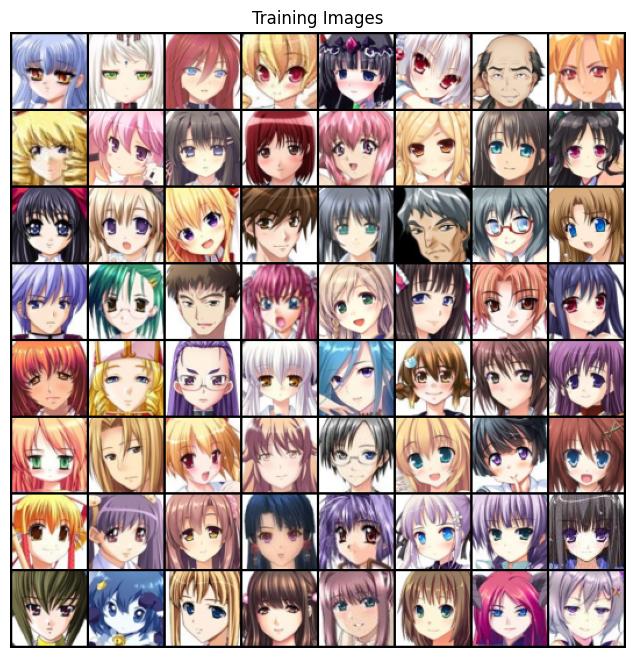

In [7]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [8]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu, nz, ngf, nc):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

Now, we can instantiate the generator and apply the `weights_init`
function. Check out the printed model to see how the generator object is
structured.


In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, ndf, nc):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
def objective(trial):
    print(f"Starting trial {trial.number}...")

    # Define hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)  # Learning rate
    nz = trial.suggest_int('nz', 50, 200)  # Latent vector size
    ngf = trial.suggest_categorical('ngf', [32, 64, 128])  # Generator feature maps
    ndf = trial.suggest_categorical('ndf', [32, 64, 128])  # Discriminator feature maps
    beta1 = trial.suggest_float('beta1', 0.3, 0.9)  # Tuning beta1

    # Initialize models
    # Create the generator
    netG = Generator(ngpu=ngpu, nz=nz, ngf=ngf, nc=nc).to(device)

    # Handle multi-GPU if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netG = nn.DataParallel(netG, list(range(ngpu)))

    # Apply the ``weights_init`` function to randomly initialize all weights
    #  to ``mean=0``, ``stdev=0.02``.
    netG.apply(weights_init)

    # Create the Discriminator
    netD = Discriminator(ngpu=ngpu, ndf=ndf, nc=nc).to(device)

    # Handle multi-GPU if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netD = nn.DataParallel(netD, list(range(ngpu)))

    # Apply the ``weights_init`` function to randomly initialize all weights
    # like this: ``to mean=0, stdev=0.2``.
    netD.apply(weights_init)


    # Set up Adam optimizers
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    # Binary Cross Entropy Loss
    criterion = nn.BCELoss()

    # Initialize fixed noise for evaluation
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    # Training loop
    for epoch in range(num_epochs):
        epoch_D_loss = 0
        epoch_G_loss = 0
        print(f"Epoch {epoch+1}/{num_epochs}...")

        for i, data in enumerate(tqdm(dataloader, desc=f"Training Epoch {epoch+1}"), 0):
            ############################
            # (1) Update D network
            ###########################
            netD.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), 1., dtype=torch.float, device=device)

            # Flatten the output of the discriminator
            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(0.)
            # Flatten the output of the discriminator
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            ############################
            # (2) Update G network
            ###########################
            netG.zero_grad()
            label.fill_(1.)  # fake labels are real for generator cost
            # Flatten the output of the discriminator
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            # Save losses for later analysis
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            epoch_D_loss += errD.item()
            epoch_G_loss += errG.item()

            if iters % 50 == 0:
                print(f"Iteration {iters}: Loss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}")

            iters += 1

        # Log the average losses for the epoch
        print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss D: {epoch_D_loss / len(dataloader):.4f} - Avg Loss G: {epoch_G_loss / len(dataloader):.4f}")

        # Save generated images
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    # Final loss for the objective function
    final_loss = sum(D_losses)
    print(f"Trial {trial.number} complete - Total Discriminator Loss: {final_loss:.4f}")
    return final_loss  # Minimize the discriminator loss

In [12]:
# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)  # Run 5 trials to explore different hyperparameters

# Print the best hyperparameters found
print("Best hyperparameters: ", study.best_params)

# After the study is complete, you can retrieve the best model settings
best_hyperparams = study.best_params
print(f"Best Hyperparameters: {best_hyperparams}")

[I 2025-06-01 02:40:43,333] A new study created in memory with name: no-name-f0e544b7-8a0a-434b-b592-6e6c15533213
<ipython-input-11-aeb8b720a88c>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)  # Learning rate


Starting trial 0...
Epoch 1/5...


Training Epoch 1:   0%|          | 1/497 [00:13<1:51:31, 13.49s/it]

Iteration 0: Loss_D: 1.7147	Loss_G: 1.9727


Training Epoch 1:   0%|          | 1/497 [00:22<3:02:01, 22.02s/it]
[W 2025-06-01 02:41:05,668] Trial 0 failed with parameters: {'lr': 0.0002244099131719193, 'nz': 153, 'ngf': 128, 'ndf': 32, 'beta1': 0.84355478629849} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-11-aeb8b720a88c>", line 78, in objective
    errD_fake.backward()
  File "/usr/local/lib/python3.11/dist-packages/torch/_tensor.py", line 626, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.11/dist-packages/torch/autograd/__init__.py", line 347, in backward
    _engine_run_backward(
  File "/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py", line 823, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to r

KeyboardInterrupt: 

In [ ]:
#Best Hyperparameters from Optuna Hyperparameter Tuning
lr = best_hyperparams['lr']
nz = best_hyperparams['nz']
ngf = best_hyperparams['ngf']
ndf = best_hyperparams['ndf']
beta1 = best_hyperparams['beta1']

# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Initialize models
# Create the generator
netG = Generator(ngpu=ngpu, nz=nz, ngf=ngf, nc=1).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

# Create the Discriminator
netD = Discriminator(ngpu=ngpu, ndf=ndf, nc=1).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

real_label = 1.
fake_label = 0.

# Set up Adam optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Initialize fixed noise for evaluation
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

#Training Loop
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()